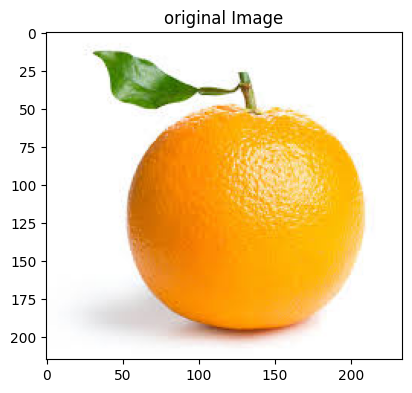

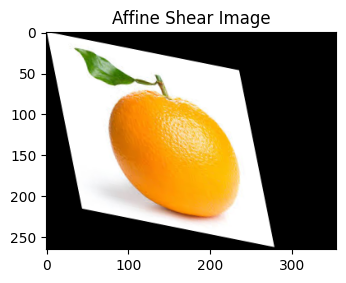

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

def display_image(image, title, size = 5):
    width, height = image.shape[0], image.shape[1]
    aspect_ratio = width / height
    plt.figure(figsize=(size * aspect_ratio, size))
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title(title)
    plt.show()

img = cv2.imread('orange.jpg',1)
rows, cols, chan = img.shape
M = np.float32([[1,0.2,0], [0.2,1,0]])
dst = cv2.warpAffine(img, M, (cols + 120, rows + 50))

display_image(img, 'original Image')
display_image(dst, 'Affine Shear Image')

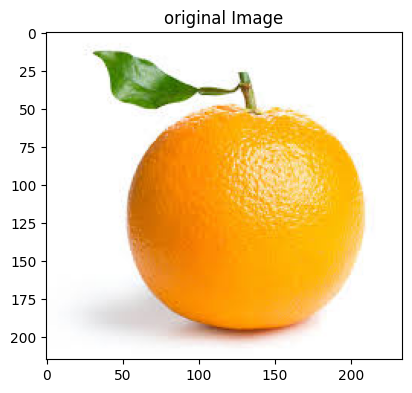

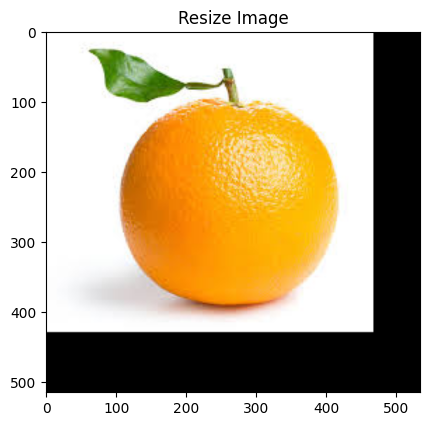

In [3]:
img = cv2.imread('orange.jpg',1)
rows, cols, chan = img.shape
M = np.float32([[2,0,0], [0,2,0]])
dst = cv2.warpAffine(img, M, (cols + 300, rows + 300))

display_image(img, 'original Image')
display_image(dst, 'Resize Image')

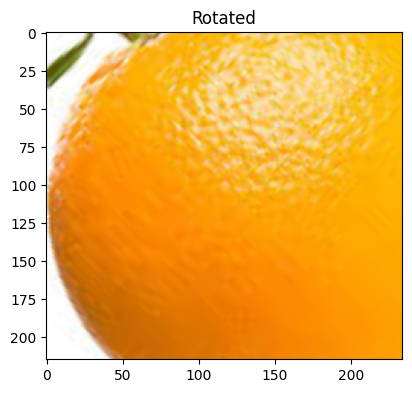

In [9]:

(h, w) = img.shape[:2]
center = (w // 2, h // 2)

matrix = cv2.getRotationMatrix2D(center, 45, 2.0)

rotated_image = cv2.warpAffine(img, matrix, (w, h))

display_image(rotated_image, "Rotated")

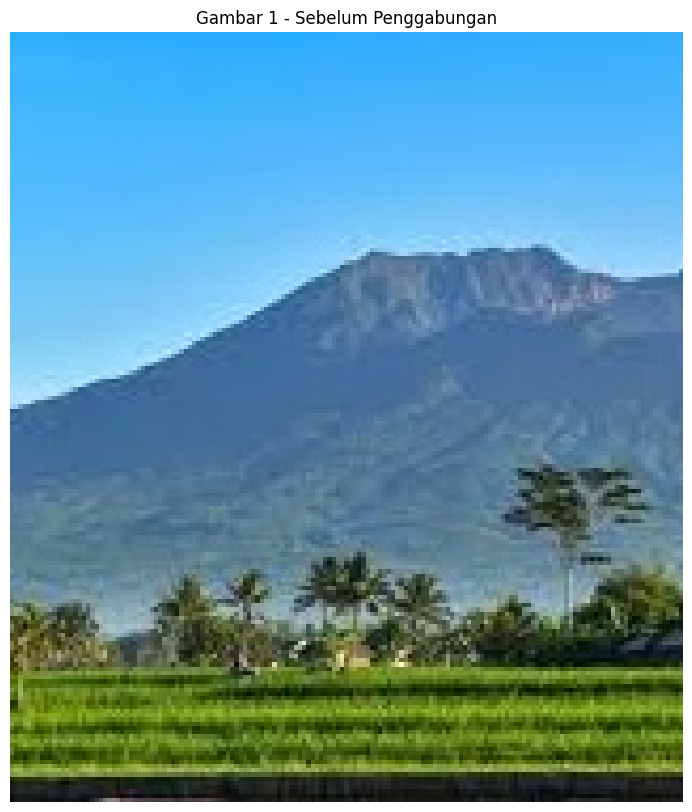

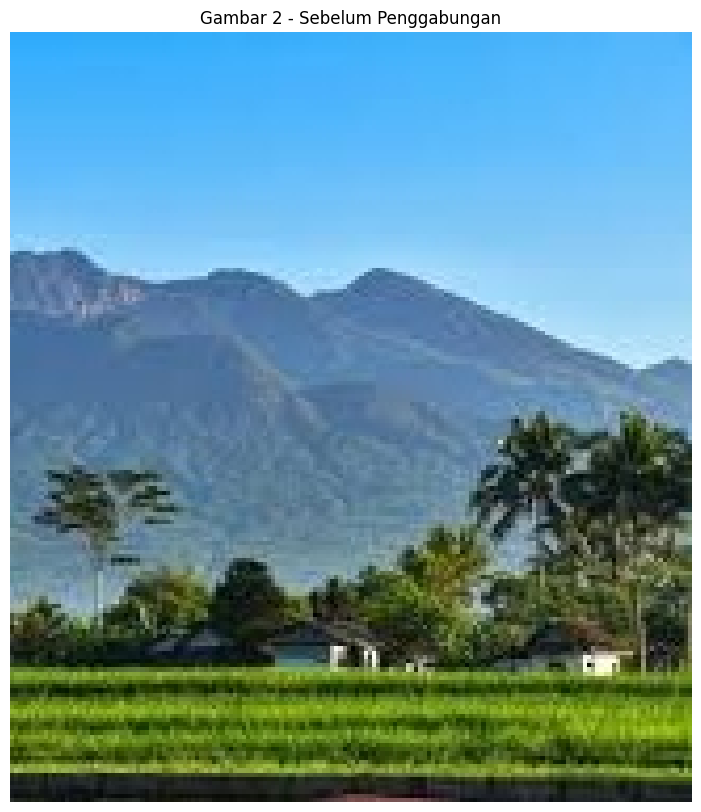

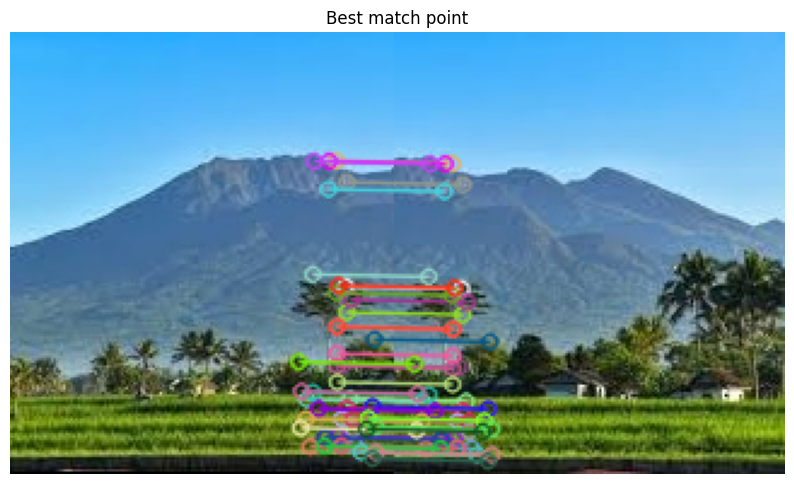

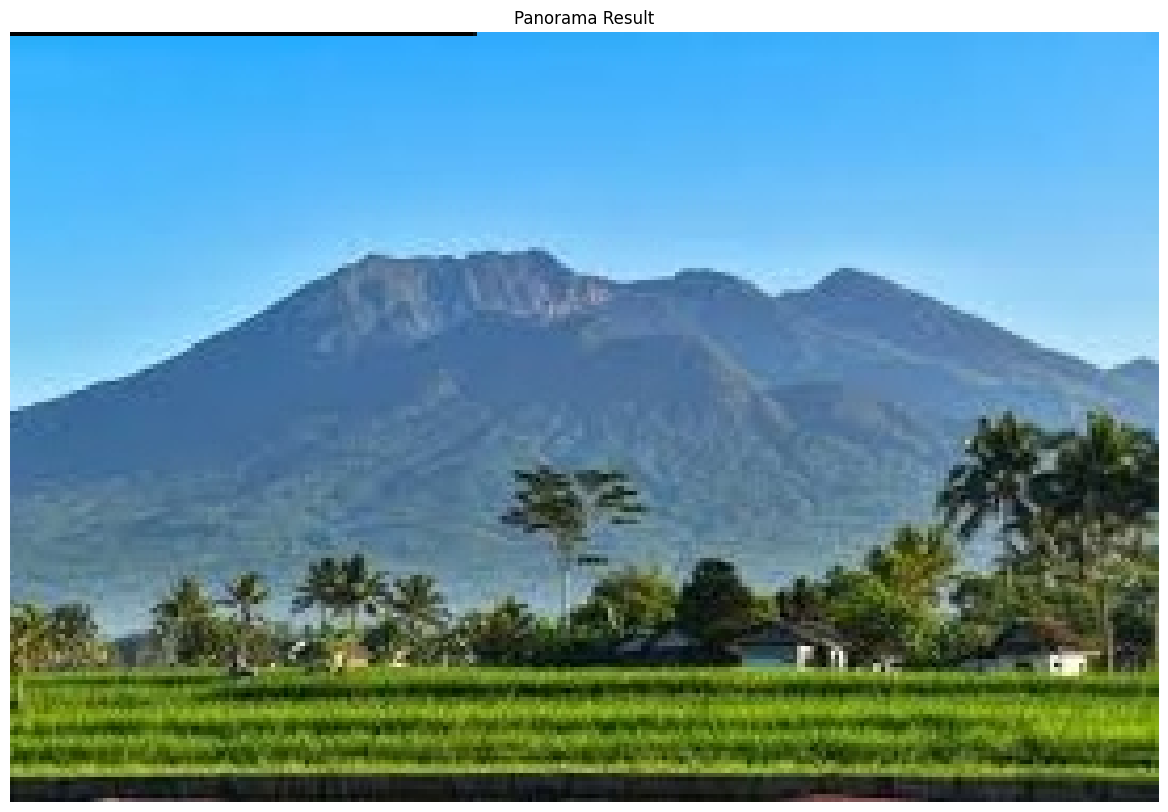

In [8]:
def display_image(image, title='Image', size=(10, 10)):

    plt.figure(figsize=size)
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title(title)
    plt.axis('off')
    plt.show()

def resize_image(image, height=None, width=None):

    (h, w) = image.shape[:2]
    if height is None and width is None:
        return image
    if height is not None:
        r = height / float(h)
        dim = (int(w * r), height)
    else:
        r = width / float(w)
        dim = (width, int(h * r))
    resized = cv2.resize(image, dim, interpolation=cv2.INTER_AREA)
    return resized

def stitch_images_manual(img1_path, img2_path):

    img1 = cv2.imread(img1_path)
    img2 = cv2.imread(img2_path)

    if img1 is None or img2 is None:
        print("Error: Image not found")
        return None

    
    display_image(img1, 'Gambar 1 - Sebelum Penggabungan')
    display_image(img2, 'Gambar 2 - Sebelum Penggabungan')

    # SIFT
    sift = cv2.SIFT_create()
    keypoints1, descriptors1 = sift.detectAndCompute(img1, None)
    keypoints2, descriptors2 = sift.detectAndCompute(img2, None)

    #  BFMatcher
    bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)
    matches = bf.match(descriptors1, descriptors2)

    # shorting match point depends on the distance
    matches = sorted(matches, key=lambda x: x.distance)

   
    matched_img = cv2.drawMatches(img1, keypoints1, img2, keypoints2, matches[:50], None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
    display_image(matched_img, 'Best match point')

    # only choosing good matches
    good_matches = matches[:30]

    if len(good_matches) < 4:
        print("Error: Not enough match point.")
        return None

    
    pts1 = np.float32([keypoints1[m.queryIdx].pt for m in good_matches]).reshape(-1,1,2)
    pts2 = np.float32([keypoints2[m.trainIdx].pt for m in good_matches]).reshape(-1,1,2)

    
    H, mask = cv2.findHomography(pts2, pts1, cv2.RANSAC, 5.0)

    if H is None:
        print("Error: Homografi tidak dapat dihitung.")
        return None

    
    height1, width1 = img1.shape[:2]
    height2, width2 = img2.shape[:2]

    
    corners_img2 = np.float32([[0,0], [0, height2], [width2, height2], [width2, 0]]).reshape(-1,1,2)
    corners_img2_transformed = cv2.perspectiveTransform(corners_img2, H)

    
    corners = np.concatenate((corners_img2_transformed, np.float32([[0,0], [0, height1], [width1, height1], [width1, 0]]).reshape(-1,1,2)), axis=0)
    [x_min, y_min] = np.int32(corners.min(axis=0).ravel() - 0.5)
    [x_max, y_max] = np.int32(corners.max(axis=0).ravel() + 0.5)
    translation_dist = [-x_min, -y_min]
    H_translation = np.array([[1, 0, translation_dist[0]],
                              [0, 1, translation_dist[1]],
                              [0, 0, 1]])

    
    panorama = cv2.warpPerspective(img2, H_translation.dot(H), (x_max - x_min, y_max - y_min))
    
    panorama[translation_dist[1]:height1 + translation_dist[1], translation_dist[0]:width1 + translation_dist[0]] = img1

    return panorama

if __name__ == "__main__":
    
    img1_path = 'Picture1.jpg'  
    img2_path = 'Picture2.jpg'  

    
    panorama = stitch_images_manual(img1_path, img2_path)

    if panorama is not None:
        display_image(panorama, 'Panorama Result', size=(15, 10))


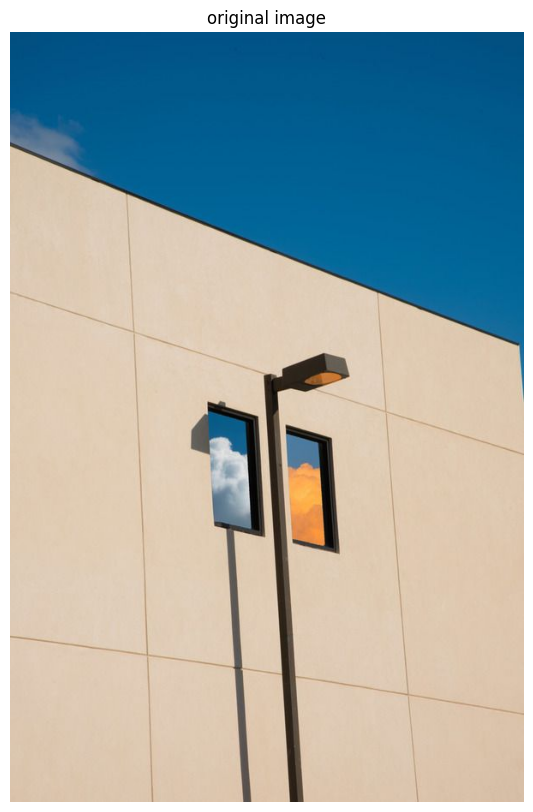

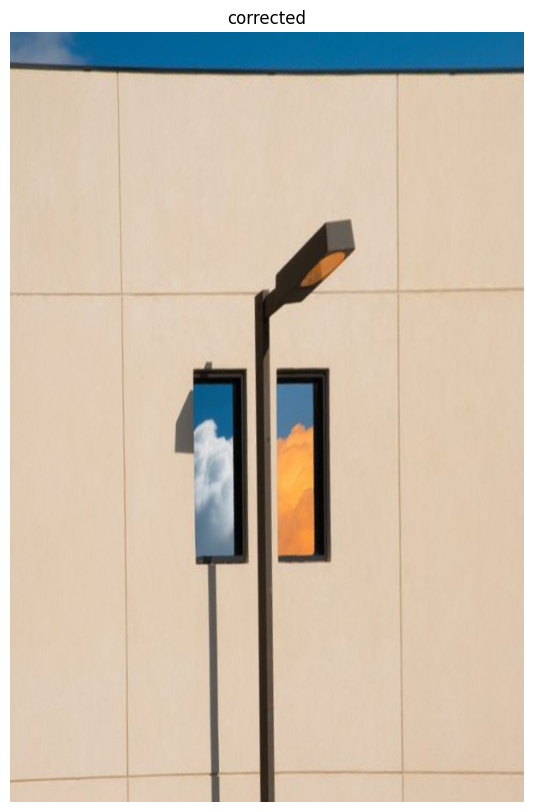

In [22]:
image = cv2.imread('lamp.jpg')

pts_src = np.array([[0,100], [600, 300], [500,800], [0,800]])

width, height = 600, 900
pts_dst = np.array([[0,-10], [700, -100], [500, 900], [0,1000]])

homography, status = cv2.findHomography(pts_src, pts_dst)

corrected = cv2.warpPerspective(image, homography, (width, height))

display_image(image, 'original image')
display_image(corrected, 'corrected')